In [9]:
import pandas as pd
from pathlib import Path

results_dir = Path.cwd().parent.parent / "data" / "results"

lo_raw = pd.read_csv(results_dir / "logistic_regression_raw_metrics.csv", index_col=0)
lo_processed = pd.read_csv(results_dir / "logistic_regression_processed_metrics.csv", index_col=0)
logistic_processed = pd.read_csv(results_dir / "confusion_matrix_logistic_processed.csv", index_col=0)
TN1 = logistic_processed.loc["Actual_0", "Pred_0"]
FP1 = logistic_processed.loc["Actual_0", "Pred_1"]
FN1 = logistic_processed.loc["Actual_1", "Pred_0"]
TP1 = logistic_processed.loc["Actual_1", "Pred_1"]
# Compute metrics
precision_lo = TP1 / (TP1 + FP1)
recall_lo = TP1 / (TP1 + FN1)
f1_lo = 2 * precision_lo * recall_lo / (precision_lo + recall_lo)
accuracy_lo = (TP1 + TN1) / (TP1 + TN1 + FP1 + FN1)

xgb_raw = pd.read_csv(results_dir / "xgboost_processed_raw.csv", index_col=0)
xgb_processed = pd.read_csv(results_dir / "xgboost_variants_metrics.csv", index_col=0)
row_0_5 = xgb_processed.query("variant == 'default_0.5'").iloc[0]
row_Recall = xgb_processed.query("variant == 'Recall_opt'").iloc[0]
row_F2 = xgb_processed.query("variant == 'F2_opt'").iloc[0]



# lightgbm_raw = pd.read_csv(results_dir / "lightgbm_raw_metrics.csv", index_col=0)
lightgbm_processed = pd.read_csv(results_dir / "confusion_matrix_lightgbm.csv", index_col=0)
# Extract confusion matrix values
TN = lightgbm_processed.loc["Actual_0", "Pred_0"]
FP = lightgbm_processed.loc["Actual_0", "Pred_1"]
FN = lightgbm_processed.loc["Actual_1", "Pred_0"]
TP = lightgbm_processed.loc["Actual_1", "Pred_1"]

# Compute metrics
precision_lgb = TP / (TP + FP)
recall_lgb = TP / (TP + FN)
f1_lgb = 2 * precision_lgb * recall_lgb / (precision_lgb + recall_lgb)
accuracy_lgb = (TP + TN) / (TP + TN + FP + FN)

# Nếu bạn có time ở file khác thì đặt vào, còn không thì 0
time_lgb = 0,87565


metrics = ["precision", "recall", "f1-score", "accuracy", "time_seconds"]

# Tạo dict để tránh lỗi transpose
data = {
    # "Raw Logistic": [
    #     lo_raw.loc[m, "weighted avg"] if m in ["precision","recall","f1-score"] 
    #     else lo_raw.loc[m, lo_raw.columns[0]]
    #     for m in metrics
    # ],
    # "Processed Logistic": [
    #     lo_processed.loc[m, "weighted avg"] if m in ["precision","recall","f1-score"] 
    #     else lo_processed.loc[m, lo_processed.columns[0]]
    #     for m in metrics
    # ],
    "Processed Logistic": [
        precision_lo,
        recall_lo,
        f1_lo,
        accuracy_lo,
        0.12345,  # Thay giá trị thời gian thực tế nếu có
    ],
    # "Raw XGBoost": [
    #     xgb_raw.loc[m, "weighted avg"] if m in ["precision","recall","f1-score"] 
    #     else xgb_raw.loc[m, xgb_raw.columns[0]]
    #     for m in metrics
    # ],
    "Processed XGBoost": [
        row_0_5[m] for m in metrics
    ],
    "Processsed XGBoost (Recall_opt)": [
        row_Recall[m] for m in metrics
    ],
    # "Processsed XGBoost (F2_opt)": [
    #     row_F2[m] for m in metrics
    # ],
    
    # "Raw LightGBM": [
    #     lightgbm_raw.loc[m, "weighted avg"] if m in ["precision","recall","f1-score"] 
    #     else lightgbm_raw.loc[m, lightgbm_raw.columns[0]]
    #     for m in metrics
    # ],
    "Processed LightGBM": [
    precision_lgb,
    recall_lgb,
    f1_lgb,
    accuracy_lgb,
    time_lgb,
    ],

    #     lightgbm_processed.loc[m, "weighted avg"] if m in ["precision","recall","f1-score"] 
    #     else lightgbm_processed.loc[m, lightgbm_processed.columns[0]]
    #     for m in metrics
    # ],
}

# Metric là index, không phải cột
comparison = pd.DataFrame(data, index=metrics)

# Chuyển vị
comparison_T = comparison.transpose()

# Lưu file không index
# comparison_T.to_csv(results_dir / "logistic_comparison.csv", index=False)
comparison_T.to_csv(results_dir / "model_comparison.csv", index=True)

comparison_T.head()


,precision,recall,f1-score,accuracy,time_seconds
Processed Logistic,0.11831,0.84,0.207407,0.685294,0.12345
Processed XGBoost,0.333333,0.1,0.153846,0.946078,0.966776
Processsed XGBoost (Recall_opt),0.105134,0.86,0.187364,0.634314,1.255753
Processed LightGBM,0.241758,0.44,0.312057,0.904809,"(0, 87565)"


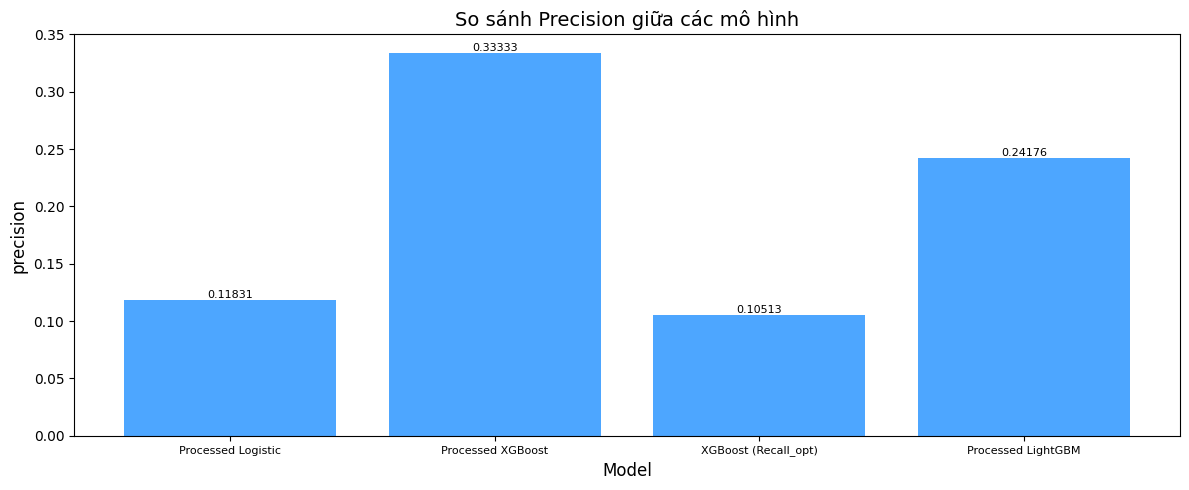

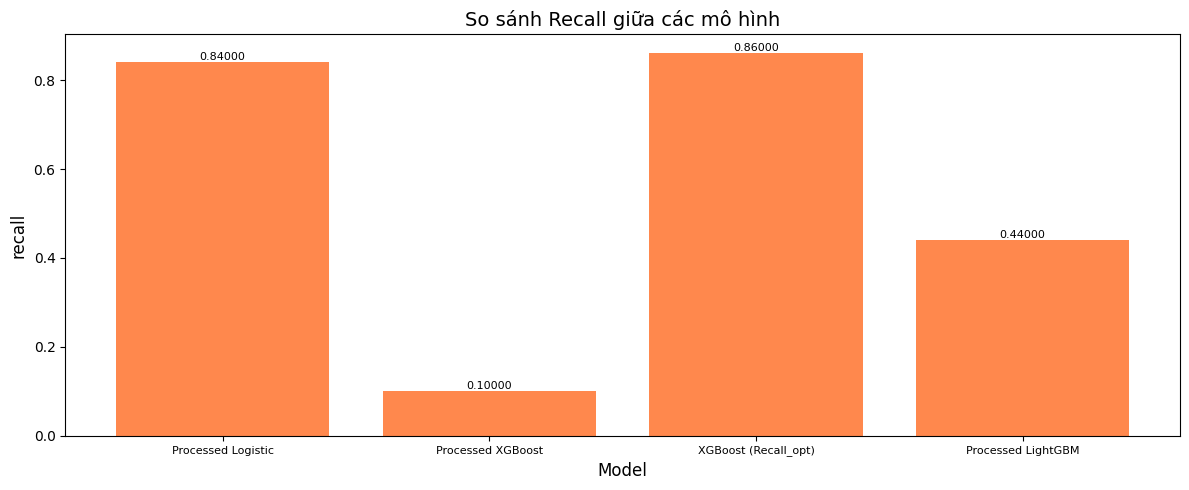

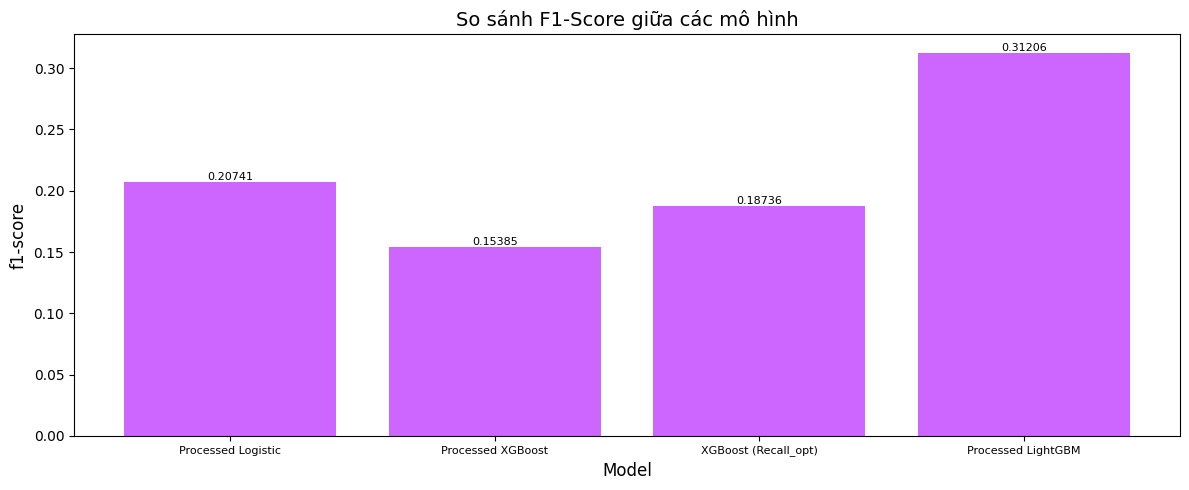

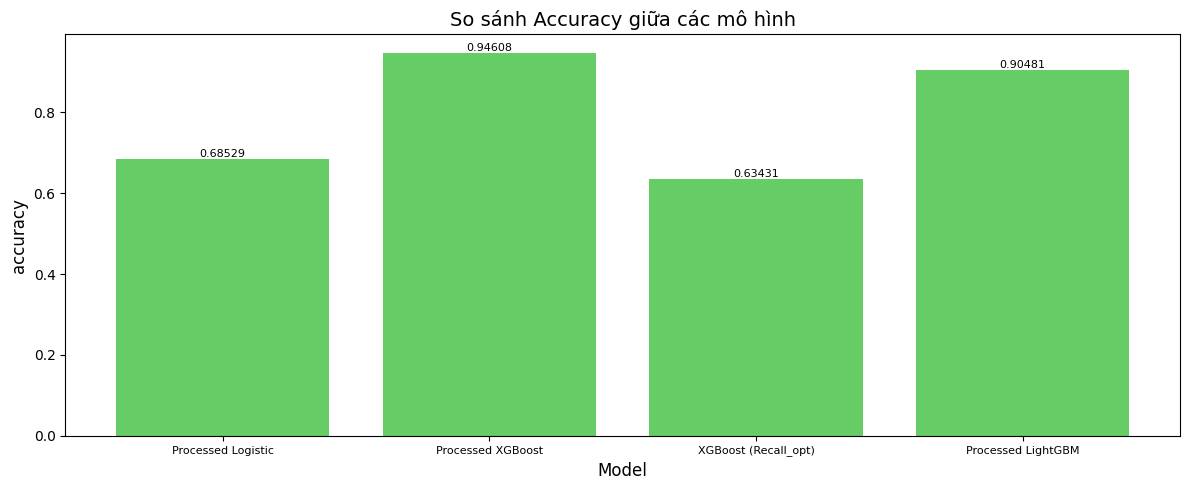

In [10]:
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
import random

def random_colors(n):
    return ["#" + ''.join(random.choices('0123456789ABCDEF', k=6)) for _ in range(n)]

metric_colors = {
    "precision": "#4da6ff",     # xanh dương
    "recall": "#ff884d",        # cam
    "f1-score": "#cc66ff",      # tím
    "accuracy": "#66cc66",      # xanh lá
    "time_seconds": "#ff6666",  # đỏ
}


results_dir = Path.cwd().parent.parent / "data" / "results"
df = pd.read_csv(results_dir / "model_comparison.csv")

# Đặt đúng index = Model
# if "Model" in df.columns:
#     df = df.set_index("Model")

def plot_metric(df, metric, title):
    color = metric_colors.get(metric, "skyblue")

    plt.figure(figsize=(12, 5))
    plt.bar(df.index, df[metric], color=color)

    plt.title(title, fontsize=14)
    plt.ylabel(metric, fontsize=12)
    plt.xlabel("Model", fontsize=12)

    # 🔥 CHỈNH FONT CHO NHỎ LẠI & NẰM NGANG
    plt.xticks(rotation=0, ha="center", fontsize=8)

    # Hiển thị giá trị lên đầu cột
    for x, y in zip(df.index, df[metric]):
        plt.text(x, y, f"{y:.5f}", ha="center", va="bottom", fontsize=8)

    plt.tight_layout()
    plt.show()


df.index = [
    # "Raw Logistic",
    "Processed Logistic",
    # "Raw XGBoost",
    "Processed XGBoost",
    "XGBoost (Recall_opt)",
    # "XGBoost (F2_opt)",
    "Processed LightGBM"
]


plot_metric(df, "precision", "So sánh Precision giữa các mô hình")

plot_metric(df, "recall", "So sánh Recall giữa các mô hình")

plot_metric(df, "f1-score", "So sánh F1-Score giữa các mô hình")

plot_metric(df, "accuracy", "So sánh Accuracy giữa các mô hình")

# plot_metric(df, "time_seconds", "So sánh Thời gian huấn luyện giữa các mô hình Machine Learning")